In [1]:
import xarray as xr
import numpy as np
import xgcm
import xmitgcm
from matplotlib import pyplot as plt
%matplotlib inline
import os
#plt.rcParams['figure.figsize'] = (12,6)
import glob
import ecco_v4_py as ecco
from matplotlib import cm
import xrft
#from MITgcmutils import mds
import xesmf as xe
import scicomap as sc
import cmocean
import pandas as pd
import pyinterp

mesh = pyinterp.RTree()

div_map = sc.ScicoMiscellaneous(cmap='rainbow-kov')
div_map.unif_sym_cmap(lift=10, bitonic=False, diffuse=True)
fixed_cmap = div_map.get_mpl_color_map()

tp = '>f4'

output_dir = '../input/'

llc540_extra_metadata = xmitgcm.utils.get_extra_metadata(domain='llc', nx=540)

# Then we read the grid from the input files
grid = xmitgcm.utils.get_grid_from_input('../run/tile<NFACET>.mitgrid',
                                         geometry='llc',
                                         extra_metadata=llc540_extra_metadata)


# define the connectivity between faces
face_connections = {'face':
                    {0: {'X':  ((12, 'Y', False), (3, 'X', False)),
                         'Y':  (None,             (1, 'Y', False))},
                     1: {'X':  ((11, 'Y', False), (4, 'X', False)),
                         'Y':  ((0, 'Y', False),  (2, 'Y', False))},
                     2: {'X':  ((10, 'Y', False), (5, 'X', False)),
                         'Y':  ((1, 'Y', False),  (6, 'X', False))},
                     3: {'X':  ((0, 'X', False),  (9, 'Y', False)),
                         'Y':  (None,             (4, 'Y', False))},
                     4: {'X':  ((1, 'X', False),  (8, 'Y', False)),
                         'Y':  ((3, 'Y', False),  (5, 'Y', False))},
                     5: {'X':  ((2, 'X', False),  (7, 'Y', False)),
                         'Y':  ((4, 'Y', False),  (6, 'Y', False))},
                     6: {'X':  ((2, 'Y', False),  (7, 'X', False)),
                         'Y':  ((5, 'Y', False),  (10, 'X', False))},
                     7: {'X':  ((6, 'X', False),  (8, 'X', False)),
                         'Y':  ((5, 'X', False),  (10, 'Y', False))},
                     8: {'X':  ((7, 'X', False),  (9, 'X', False)),
                         'Y':  ((4, 'X', False),  (11, 'Y', False))},
                     9: {'X':  ((8, 'X', False),  None),
                         'Y':  ((3, 'X', False),  (12, 'Y', False))},
                     10: {'X': ((6, 'Y', False),  (11, 'X', False)),
                          'Y': ((7, 'Y', False),  (2, 'X', False))},
                     11: {'X': ((10, 'X', False), (12, 'X', False)),
                          'Y': ((8, 'Y', False),  (1, 'X', False))},
                     12: {'X': ((11, 'X', False), None),
                          'Y': ((9, 'Y', False),  (0, 'X', False))}}}


In [2]:
def writeptracers(ptracer, ds, llc540_extra_metadata, outputdir, sitename):
    ptracer_longqi = ptracer.copy()
    ptracer_longqi[ptracer_longqi<1e5] = 0.


    relaxmask_longqi = ptracer_longqi.copy()
    #relaxmask_longqi[relaxmask_longqi==1e5] = 1.
    relaxmask_longqi[relaxmask_longqi==1e6] = 1.


    ptracer_longqi = xr.DataArray(  ptracer_longqi, dims=("k","face", "j","i"), 
                              coords={"k": ds.k, "face": ds.face,"j":ds.j,"i":ds.i,"Z":ds.Z})
    relaxmask_longqi = xr.DataArray(  relaxmask_longqi, dims=("k","face", "j","i"), 
                                coords={"k": ds.k, "face": ds.face,"j":ds.j,"i":ds.i,"Z":ds.Z})

    facets = xmitgcm.utils.rebuild_llc_facets( ptracer_longqi,llc540_extra_metadata )
    compact = xmitgcm.utils.llc_facets_3d_spatial_to_compact(facets, 'Z',llc540_extra_metadata )
    xmitgcm.utils.write_to_binary(compact, outputdir+'ini_ptracer_'+sitename+'.bin')


    facets = xmitgcm.utils.rebuild_llc_facets( relaxmask_longqi,llc540_extra_metadata )
    compact = xmitgcm.utils.llc_facets_3d_spatial_to_compact(facets, 'Z',llc540_extra_metadata )
    xmitgcm.utils.write_to_binary(compact, outputdir+'relaxmask_'+sitename+'.bin')


    return ptracer_longqi, relaxmask_longqi

In [3]:
files = sorted(glob.glob('../rundiurnal/T*.data'))
filenumbers=[]
for i in files:
    filenumbers.append(int(i[-15:-5]))

ds = xmitgcm.open_mdsdataset(data_dir='../rundiurnal/',grid_dir='../rundiurnal/',
                             prefix=['T'],iters=filenumbers,
                             delta_t=500, geometry='llc',extra_metadata=llc540_extra_metadata)

ds['time'] = ('time', ds.time.values+np.datetime64('2037-12-31 12:00:00') )

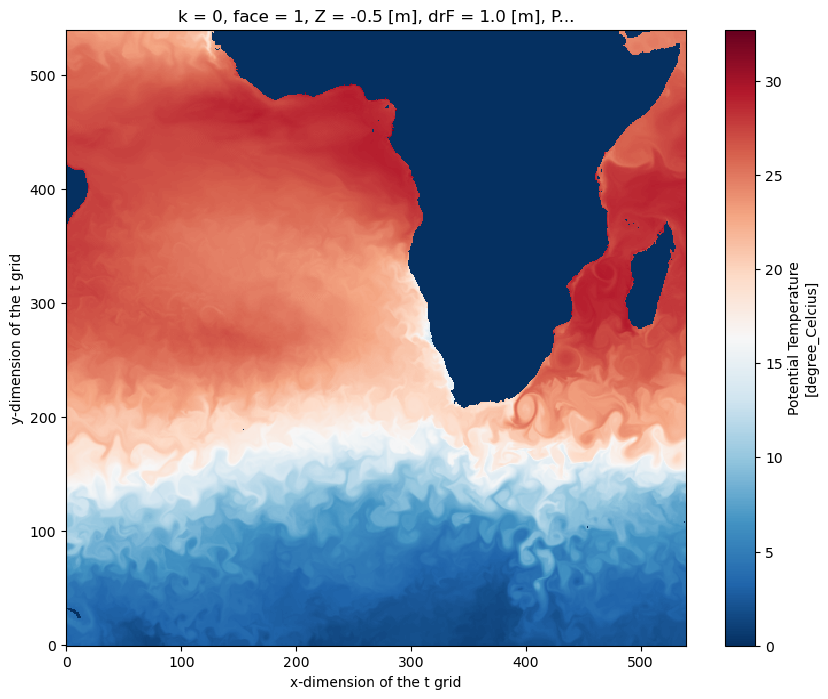

In [5]:
ds.T[-1,0,1].plot(cmap='RdBu_r',figsize=(10,8))

In [4]:
site    = ['Solitaire',      'Wocan',      'Kairei',   'Onnuri',     'Tiancheng',    'Duanqiao',       'Longqi']
lonall    = np.array([ 65.848167,     60.505555,    70.040333, 66.42366666666666,   63.92166666666667,   50.4, 49.64938333333333] )
latall    = np.array([-19.556833,      6.376666,   -25.320500, -11.414666666666667, -27.85,  -37.65,  -37.78378333333333 ]  )
#kall    = [22, 28, 37]


### additional sites

In [6]:
site    = ['newsite1',      'newsite2']
lonall    = np.array([ 67.77,   58.967] )
latall    = np.array([-1.6768, -31.067 ]  )
#kall    = [22, 28, 37]


In [7]:
topo540 = xr.open_dataarray( 'Depth.20850101.nc' ).sel(lon=slice(48,71),lat=slice(-39,8))

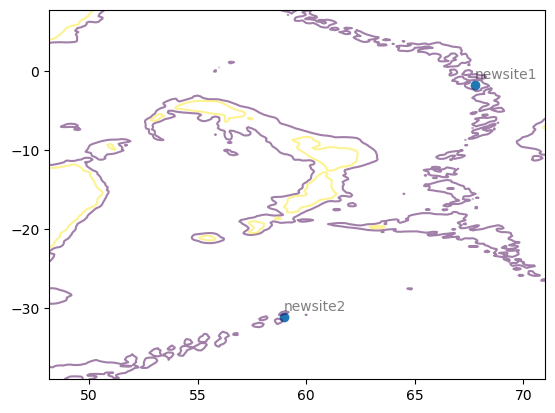

In [9]:
plt.scatter(lonall, latall)
plt.contour(topo540.lon,topo540.lat,-topo540,levels=[-3000,-1000],alpha=0.5)
for i in range(len(lonall)):
    plt.text(lonall[i],latall[i]+0.75,site[i], alpha=0.5 )

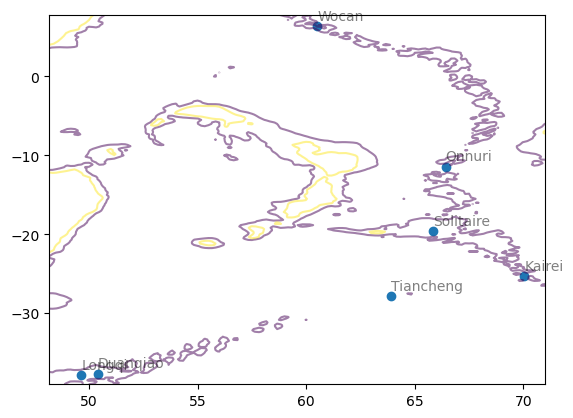

In [77]:
plt.scatter(lonall, latall)
plt.contour(topo540.lon,topo540.lat,-topo540,levels=[-3000,-1000],alpha=0.5)
for i in range(7):
    plt.text(lonall[i],latall[i]+0.75,site[i], alpha=0.5 )

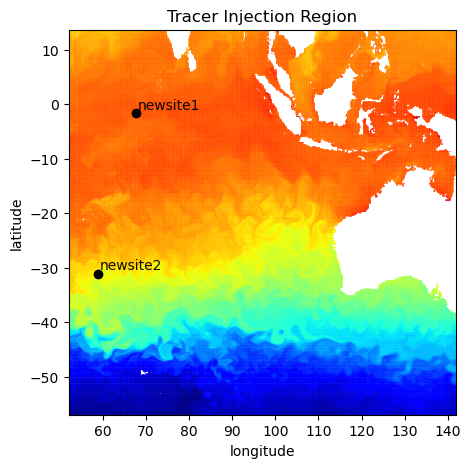

In [15]:
# pull out lats and lons
tile_num = 4
kz = 10
lons = ds.XC.sel(face=tile_num).values
lats = ds.YC.sel(face=tile_num).values
it00 = np.where((lons==0)&(lats==0))
lons[it00] = np.nan
lats[it00] = np.nan

tile_to_plot = ds.T.isel(face=tile_num, time=-1, k = kz)
tile_to_plot= tile_to_plot.where(ds.hFacC.isel(face=tile_num,k=kz ) !=0, np.nan).values

tile_to_plot[it00] = np.nan



fig=plt.figure(figsize=(5, 5))
# use contourf with 'lons' and 'lats' for the plot x and y axes
plt.pcolor(lons, lats, tile_to_plot, cmap='jet',alpha=0.5)
plt.title('Tracer Injection Region')
plt.xlim(np.nanmin(lons),np.nanmax(lons))
plt.ylim(np.nanmin(lats),np.nanmax(lats))
plt.xlabel('longitude')
plt.ylabel('latitude')

plt.scatter(lonall, latall, c='k')
for i in range(len(lonall)):
    plt.text(lonall[i]+0.25,latall[i]+0.75,site[i], alpha=0.95 )


In [13]:
itx = []
ity = []
for i in range(len(lonall)):
    it = np.where((lons>=lonall[i]-1/6./2.) & (lons<=lonall[i]+1/6./2.) & (lats>=latall[i]-1/6./2.) & (lats<=latall[i]+1/6./2.))
    print(it, ' in  Site of ', site[i])
    itx.append(it[0][0])
    ity.append(it[1][0])

(array([439]), array([94]))  in  Site of  newsite1
(array([236, 237]), array([41, 41]))  in  Site of  newsite2


In [17]:
ptracer =  ds.maskC.values.astype(float)

it = ptracer[:,tile_num, itx, ity ]

ii = 0

it0_solitaire = np.where(  it[:,ii]==0  )[0][0]-1
print(site[0],'at K=',it0_solitaire,' with hFaC ', ds.hFacC[it0_solitaire,tile_num, itx[0], ity[0]].values)
ptracer[it0_solitaire,tile_num, itx[ii], ity[ii]] = 1e6
ptracer[it0_solitaire-1,tile_num, itx[ii], ity[ii]] = 1e6

outputdir = '/data/home/liuran/MITgcm_works/llc540/input/'

sitename = site[ii] 
ptracer_solitaire, relaxmask_solitaire = writeptracers(ptracer, ds, llc540_extra_metadata, outputdir, sitename)

checkdata = xmitgcm.utils.read_raw_data(outputdir+'ini_ptracer_'+sitename+'.bin', dtype=np.dtype('>f4'),  shape=(63,7020,540) )
ik, ij, ii = np.where(checkdata>0)
print(ik, ij-540*4, ii)

newsite1 at K= 56  with hFaC  0.3
[55 56] [2599 2599] [94 94]


In [22]:
ptracer =  ds.maskC.values.astype(float)

it = ptracer[:,tile_num, itx, ity ]

ii = 1

it0_solitaire = np.where(  it[:,ii]==0  )[0][0]-1
print(site[ii],'at K=',it0_solitaire,' with hFaC ', ds.hFacC[it0_solitaire,tile_num, itx[0], ity[0]].values)
ptracer[it0_solitaire,tile_num, itx[ii], ity[ii]] = 1e6
ptracer[it0_solitaire-1,tile_num, itx[ii], ity[ii]] = 1e6

outputdir = '/data/home/liuran/MITgcm_works/llc540/input/'

sitename = site[ii] 
ptracer_solitaire, relaxmask_solitaire = writeptracers(ptracer, ds, llc540_extra_metadata, outputdir, sitename)

checkdata = xmitgcm.utils.read_raw_data(outputdir+'ini_ptracer_'+sitename+'.bin', dtype=np.dtype('>f4'),  shape=(63,7020,540) )
ik, ij, ii = np.where(checkdata>0)
print(ik, ij-540*4, ii)

newsite2 at K= 58  with hFaC  0.0
[57 58] [236 236] [41 41]


In [23]:
1264896*500/86400/365

20.054794520547944

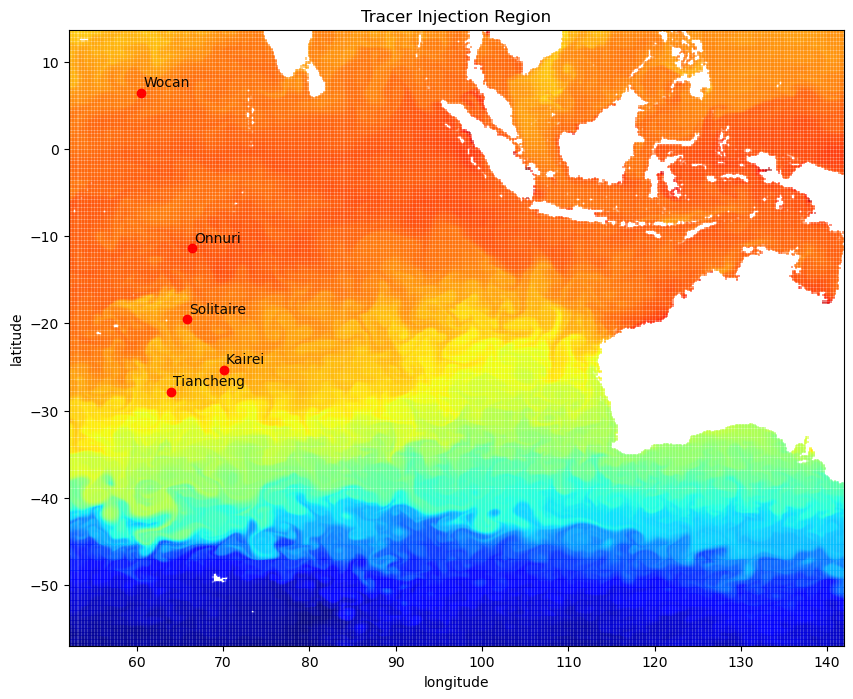

In [7]:
# pull out lats and lons
tile_num = 4
kz = 10
lons = ds.XC.sel(face=tile_num).values
lats = ds.YC.sel(face=tile_num).values
it00 = np.where((lons==0)&(lats==0))
lons[it00] = np.nan
lats[it00] = np.nan

tile_to_plot = ds.T.isel(face=tile_num, time=-1, k = kz)
tile_to_plot= tile_to_plot.where(ds.hFacC.isel(face=tile_num,k=kz ) !=0, np.nan).values

tile_to_plot[it00] = np.nan



fig=plt.figure(figsize=(10, 8))
# use contourf with 'lons' and 'lats' for the plot x and y axes
plt.pcolor(lons, lats, tile_to_plot, cmap='jet',alpha=0.5)
plt.title('Tracer Injection Region')
plt.xlim(np.nanmin(lons),np.nanmax(lons))
plt.ylim(np.nanmin(lats),np.nanmax(lats))
plt.xlabel('longitude')
plt.ylabel('latitude')

plt.scatter(lonall, latall, c='r')
for i in range(5):
    plt.text(lonall[i]+0.25,latall[i]+0.75,site[i], alpha=0.95 )


In [8]:
itx = []
ity = []
for i in range(5):
    it = np.where((lons>=lonall[i]-1/6./2.) & (lons<=lonall[i]+1/6./2.) & (lats>=latall[i]-1/6./2.) & (lats<=latall[i]+1/6./2.))
    print(it, ' in  Site of ', site[i])
    itx.append(it[0][0])
    ity.append(it[1][0])


(array([320]), array([83]))  in  Site of  Solitaire
(array([491]), array([51]))  in  Site of  Wocan
(array([279]), array([108]))  in  Site of  Kairei
(array([375]), array([86]))  in  Site of  Onnuri
(array([261]), array([71]))  in  Site of  Tiancheng


In [32]:
ptracer =  ds.maskC.values.astype(float)

it = ptracer[:,tile_num, itx, ity ]

it0_solitaire = np.where(  it[:,0]==0  )[0][0]-1
print(site[0],'at K=',it0_solitaire,' with hFaC ', ds.hFacC[it0_solitaire,tile_num, itx[0], ity[0]].values)
ptracer[it0_solitaire,tile_num, itx[0], ity[0]] = 1e6
ptracer[it0_solitaire-1,tile_num, itx[0], ity[0]] = 1e6

outputdir = '/data/home/liuran/MITgcm_works/llc540/input/'

sitename = 'solitaire'
ptracer_solitaire, relaxmask_solitaire = writeptracers(ptracer, ds, llc540_extra_metadata, outputdir, sitename)

Solitaire at K= 51  with hFaC  0.8133136


In [36]:
checkdata = xmitgcm.utils.read_raw_data(outputdir+'ini_ptracer_'+sitename+'.bin', dtype=np.dtype('>f4'),  shape=(63,7020,540) )
ik, ij, ii = np.where(checkdata>0)
print(ik, ij, ii)

[50 51] [2480 2480] [83 83]


In [49]:
ptracer =  ds.maskC.values.astype(float)

it = ptracer[:,tile_num, itx, ity ]

it2_kairei = np.where(  it[:,2]==0  )[0][0]-1
print(site[2],'at K=',it2_kairei,' with hFaC ', ds.hFacC[it2_kairei,tile_num, itx[2], ity[2]].values)
ptracer[it2_kairei,tile_num, itx[2], ity[2]] = 1e6
ptracer[it2_kairei-1,tile_num, itx[2], ity[2]] = 1e6

outputdir = '/data/home/liuran/MITgcm_works/llc540/input/'

sitename = 'kairei'
ptracer_kairei, relaxmask_kairei = writeptracers(ptracer, ds, llc540_extra_metadata, outputdir, sitename)

Kairei at K= 53  with hFaC  1.0


In [48]:
checkdata = xmitgcm.utils.read_raw_data(outputdir+'ini_ptracer_'+sitename+'.bin', dtype=np.dtype('>f4'),  shape=(63,7020,540) )
ik, ij, ii = np.where(checkdata>0)
print(ik, ij, ii)

[52 53] [2439 2439] [108 108]


In [39]:

ptracer =  ds.maskC.values.astype(float)

it = ptracer[:,tile_num, itx, ity ]

it1_wocan = np.where(  it[:,1]==0  )[0][0]-1
print(site[1],'at K=',it1_wocan,' with hFaC ', ds.hFacC[it1_wocan,tile_num, itx[1], ity[1]].values)

ptracer[it1_wocan,tile_num, itx[1], ity[1]] = 1e6
ptracer[it1_wocan-1,tile_num, itx[1], ity[1]] = 1e6

outputdir = '/data/home/liuran/MITgcm_works/llc540/input/'

sitename = 'wocan'
ptracer_wocan, relaxmask_wocan = writeptracers(ptracer, ds, llc540_extra_metadata, outputdir, sitename)

Wocan at K= 54  with hFaC  0.74495405


In [38]:
checkdata = xmitgcm.utils.read_raw_data(outputdir+'ini_ptracer_'+sitename+'.bin', dtype=np.dtype('>f4'),  shape=(63,7020,540) )
ik, ij, ii = np.where(checkdata>0)
print(ik, ij, ii)

[53 54] [2651 2651] [51 51]


In [41]:
ptracer =  ds.maskC.values.astype(float)

it = ptracer[:,tile_num, itx, ity ]

it3_Onnuri = np.where(  it[:,3]==0  )[0][0]-1
print(site[3],'at K=',it3_Onnuri,' with hFaC ', ds.hFacC[it3_Onnuri,tile_num, itx[3], ity[3]].values)

ptracer[it3_Onnuri,tile_num, itx[3], ity[3]] = 1e6
ptracer[it3_Onnuri-1,tile_num, itx[3], ity[3]] = 1e6

outputdir = '/data/home/liuran/MITgcm_works/llc540/input/'

sitename = 'onnuri'
ptracer_onnuri, relaxmask_onnuri = writeptracers(ptracer, ds, llc540_extra_metadata, outputdir, sitename)

Onnuri at K= 53  with hFaC  0.70340675


In [42]:
checkdata = xmitgcm.utils.read_raw_data(outputdir+'ini_ptracer_'+sitename+'.bin', dtype=np.dtype('>f4'),  shape=(63,7020,540) )
ik, ij, ii = np.where(checkdata>0)
print(ik, ij, ii)

[52 53] [2535 2535] [86 86]


In [43]:
checkdata = xmitgcm.utils.read_raw_data(outputdir+'relaxmask_'+sitename+'.bin', dtype=np.dtype('>f4'),  shape=(63,7020,540) )
ik, ij, ii = np.where(checkdata>0)
print(ik, ij, ii)

[52 53] [2535 2535] [86 86]


In [46]:
ptracer =  ds.maskC.values.astype(float)

it = ptracer[:,tile_num, itx, ity ]

it4_Tiancheng = np.where(  it[:,4]==0  )[0][0]-1

ptracer[it4_Tiancheng,tile_num, itx[4], ity[4]] = 1e6
ptracer[it4_Tiancheng-1,tile_num, itx[4], ity[4]] = 1e6

print(site[4],'at K=',it4_Tiancheng,' with hFaC ', ds.hFacC[it4_Tiancheng,tile_num, itx[4], ity[4]].values)

outputdir = '/data/home/liuran/MITgcm_works/llc540/input/'

sitename = 'tiancheng'
ptracer_tiancheng, relaxmask_tiancheng = writeptracers(ptracer, ds, llc540_extra_metadata, outputdir, sitename)

Tiancheng at K= 55  with hFaC  0.3


In [45]:
checkdata = xmitgcm.utils.read_raw_data(outputdir+'ini_ptracer_'+sitename+'.bin', dtype=np.dtype('>f4'),  shape=(63,7020,540) )
ik, ij, ii = np.where(checkdata>0)
print(ik, ij, ii)

[54 55] [2421 2421] [71 71]


In [208]:

ptracer =  ds.maskC.values.astype(float)

it = ptracer[:,tile_num, itx, ity ]

it1_wocan = np.where(  it[:,1]==0  )[0][0]-1
it3_Onnuri = np.where(  it[:,3]==0  )[0][0]-1
it4_Tiancheng = np.where(  it[:,4]==0  )[0][0]-1


ptracer[it1_wocan,tile_num, itx[1], ity[1]] = 1e6
ptracer[it3_Onnuri,tile_num, itx[3], ity[3]] = 1e6
ptracer[it4_Tiancheng,tile_num, itx[4], ity[4]] = 1e6


ptracer[it1_wocan-1,tile_num, itx[1], ity[1]] = 1e5
ptracer[it3_Onnuri-1,tile_num, itx[3], ity[3]] = 1e5
ptracer[it4_Tiancheng-1,tile_num, itx[4], ity[4]] = 1e5



In [2]:
!ncdump -h ../nino_forcing/global_clim20002020_t2m_amon.nc

netcdf global_clim20002020_t2m_amon {
dimensions:
	longitude = 1440 ;
	latitude = 721 ;
	month = 12 ;
variables:
	float longitude(longitude) ;
		longitude:_FillValue = NaNf ;
		longitude:units = "degrees_east" ;
		longitude:long_name = "longitude" ;
	float latitude(latitude) ;
		latitude:_FillValue = NaNf ;
		latitude:units = "degrees_north" ;
		latitude:long_name = "latitude" ;
	int64 month(month) ;
	float t2m(month, latitude, longitude) ;
		t2m:_FillValue = NaNf ;
		t2m:units = "K" ;
		t2m:long_name = "2 metre temperature" ;
}


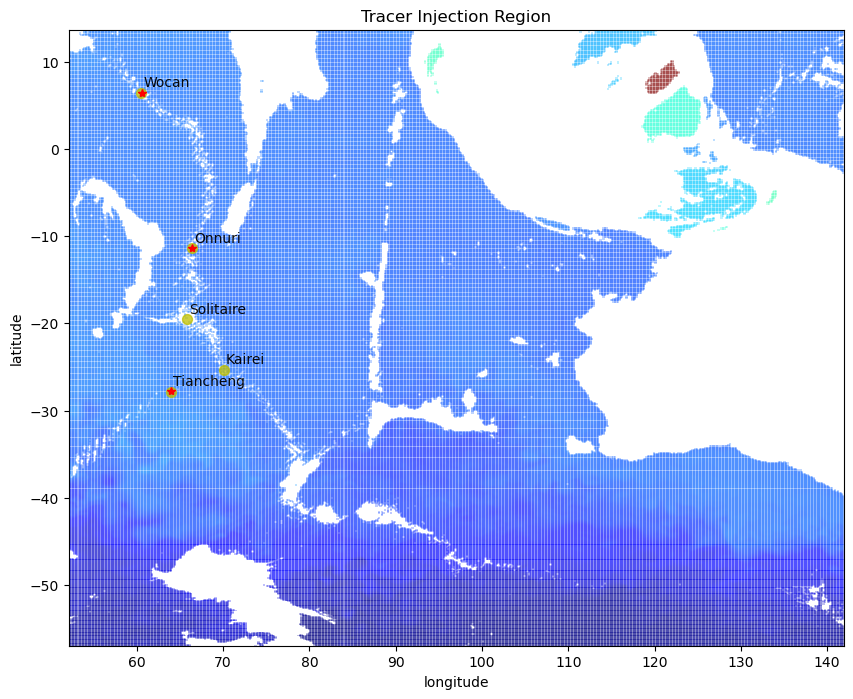

In [230]:


fig=plt.figure(figsize=(10, 8))
# use contourf with 'lons' and 'lats' for the plot x and y axes
plt.pcolor(lons, lats, ds.T[-1].where(ds.maskC)[it1_wocan,tile_num].values, cmap='jet',alpha=0.25)
plt.title('Tracer Injection Region')
plt.xlim(np.nanmin(lons),np.nanmax(lons))
plt.ylim(np.nanmin(lats),np.nanmax(lats))
plt.xlabel('longitude')
plt.ylabel('latitude')

it = np.where(ptracer[it1_wocan,tile_num]>1e5)
plt.plot( lons[it], lats[it], 'r*' )
it = np.where(ptracer[it3_Onnuri,tile_num]>1e5)
plt.plot( lons[it], lats[it], 'r*' )
it = np.where(ptracer[it4_Tiancheng,tile_num]>1e5)
plt.plot( lons[it], lats[it], 'r*' )

plt.scatter(lonall, latall,s=50, c='y',marker='o',alpha=0.75)
for i in range(5):
    plt.text(lonall[i]+0.25,latall[i]+0.75,site[i], alpha=0.95 )


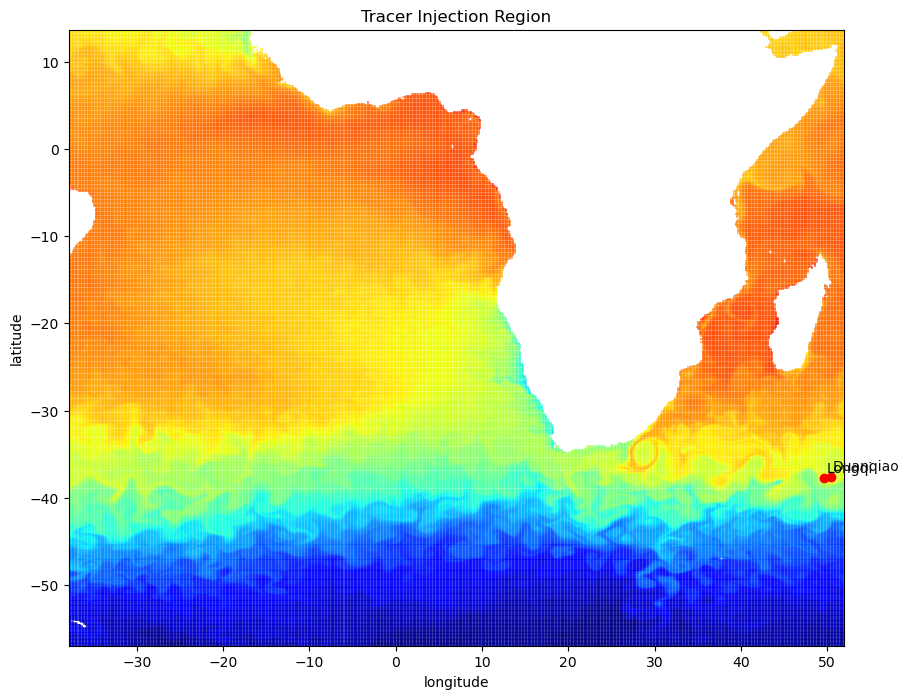

In [262]:
# pull out lats and lons
tile_num = 1
kz = 10
lons = ds.XC.sel(face=tile_num).values
lats = ds.YC.sel(face=tile_num).values
it00 = np.where((lons==0)&(lats==0))
lons[it00] = np.nan
lats[it00] = np.nan

tile_to_plot = ds.T.isel(face=tile_num, time=-1, k = kz)
tile_to_plot= tile_to_plot.where(ds.hFacC.isel(face=tile_num,k=kz ) !=0, np.nan).values

tile_to_plot[it00] = np.nan


fig=plt.figure(figsize=(10, 8))
# use contourf with 'lons' and 'lats' for the plot x and y axes
plt.pcolor(lons, lats, tile_to_plot, cmap='jet',alpha=0.5)
plt.title('Tracer Injection Region')
plt.xlim(np.nanmin(lons),np.nanmax(lons))
plt.ylim(np.nanmin(lats),np.nanmax(lats))
plt.xlabel('longitude')
plt.ylabel('latitude')

plt.scatter(lonall, latall, c='r')
for i in range(5,7):
    plt.text(lonall[i]+0.25,latall[i]+0.75,site[i], alpha=0.95 )

In [263]:
itx = []
ity = []
for i in range(5,7):
    it = np.where((lons>=lonall[i]-1/6./2.) & (lons<=lonall[i]+1/6./2.) & (lats>=latall[i]-1/6./2.) & (lats<=latall[i]+1/6./2.))
    print(it, ' in  Site of ', site[i])
    itx.append(it[0][0])
    ity.append(it[1][0])

(array([184, 185]), array([530, 530]))  in  Site of  Duanqiao
(array([183, 184]), array([525, 525]))  in  Site of  Longqi


In [264]:
ptracer =  ds.maskC.values.astype(float)

it = ptracer[:,tile_num, itx, ity ]

it6_Longqi = np.where(  it[:,1]==0  )[0][0]-1

ptracer[it6_Longqi,tile_num, itx[1], ity[1]] = 1e6
ptracer[it6_Longqi-1,tile_num, itx[1], ity[1]] = 1e5


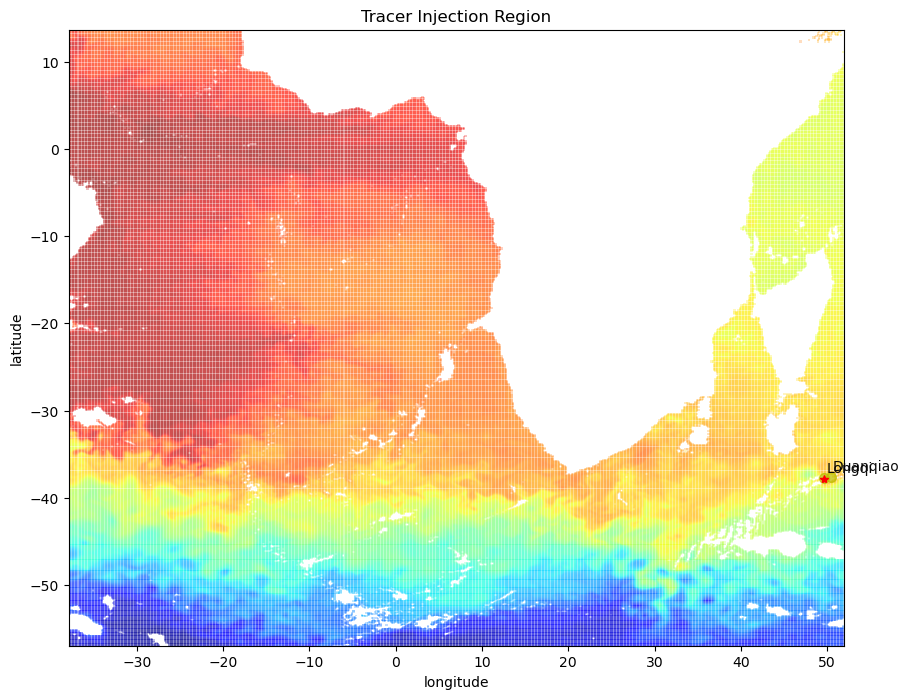

In [265]:

fig=plt.figure(figsize=(10, 8))
# use contourf with 'lons' and 'lats' for the plot x and y axes
plt.pcolor(lons, lats, ds.T[-1].where(ds.maskC)[it6_Longqi,tile_num].values, cmap='jet',alpha=0.25)
plt.title('Tracer Injection Region')
plt.xlim(np.nanmin(lons),np.nanmax(lons))
plt.ylim(np.nanmin(lats),np.nanmax(lats))
plt.xlabel('longitude')
plt.ylabel('latitude')

it = np.where(ptracer[it6_Longqi,tile_num]>1e5)
plt.plot( lons[it], lats[it], 'r*' )

plt.scatter(lonall, latall,s=50, c='y',marker='o',alpha=0.75)
for i in range(5,7):
    plt.text(lonall[i]+0.25,latall[i]+0.75,site[i], alpha=0.95 )

In [277]:
ptracer_longqi = ptracer.copy()
ptracer_longqi[ptracer_longqi<1e5] = 0.


relaxmask_longqi = ptracer_longqi.copy()
relaxmask_longqi[relaxmask_longqi==1e5] = 0.5
relaxmask_longqi[relaxmask_longqi==1e6] = 1.


outputdir = '/data/home/liuran/MITgcm_works/llc540/input/'


In [278]:
ptracer_longqi = xr.DataArray(  ptracer_longqi, dims=("k","face", "j","i"), 
                              coords={"k": ds.k, "face": ds.face,"j":ds.j,"i":ds.i,"Z":ds.Z})
relaxmask_longqi = xr.DataArray(  relaxmask_longqi, dims=("k","face", "j","i"), 
                                coords={"k": ds.k, "face": ds.face,"j":ds.j,"i":ds.i,"Z":ds.Z})

In [281]:
facets = xmitgcm.utils.rebuild_llc_facets( ptracer_longqi,llc540_extra_metadata )
compact = xmitgcm.utils.llc_facets_3d_spatial_to_compact(facets, 'Z',llc540_extra_metadata )
xmitgcm.utils.write_to_binary(compact, outputdir+'ini_ptracer_longqi.bin')


facets = xmitgcm.utils.rebuild_llc_facets( relaxmask_longqi,llc540_extra_metadata )
compact = xmitgcm.utils.llc_facets_3d_spatial_to_compact(facets, 'Z',llc540_extra_metadata )
xmitgcm.utils.write_to_binary(compact, outputdir+'relaxmask_longqi.bin')


In [ ]:
xmitgcm.utils.write_to_binary?

In [242]:
ds.drC[it6_Longqi-1:it6_Longqi+1].values

array([192.19 , 215.025], dtype='>f4')

In [243]:
ds.drC[it1_wocan-1:it1_wocan+1].values

array([238., 261.], dtype='>f4')

In [244]:
ds.drC[it3_Onnuri-1:it3_Onnuri+1].values

array([215.025, 238.   ], dtype='>f4')

In [245]:
ds.drC[it4_Tiancheng-1:it4_Tiancheng+1].values

array([261., 284.], dtype='>f4')

In [246]:
ptracer_write = ptracer.copy()
ptracer_write[ptracer_write<1e5] = 0.


relaxmask_ptracer = ptracer_write.copy()
relaxmask_ptracer[relaxmask_ptracer==1e5] = 0.5
relaxmask_ptracer[relaxmask_ptracer==1e6] = 1.



# check

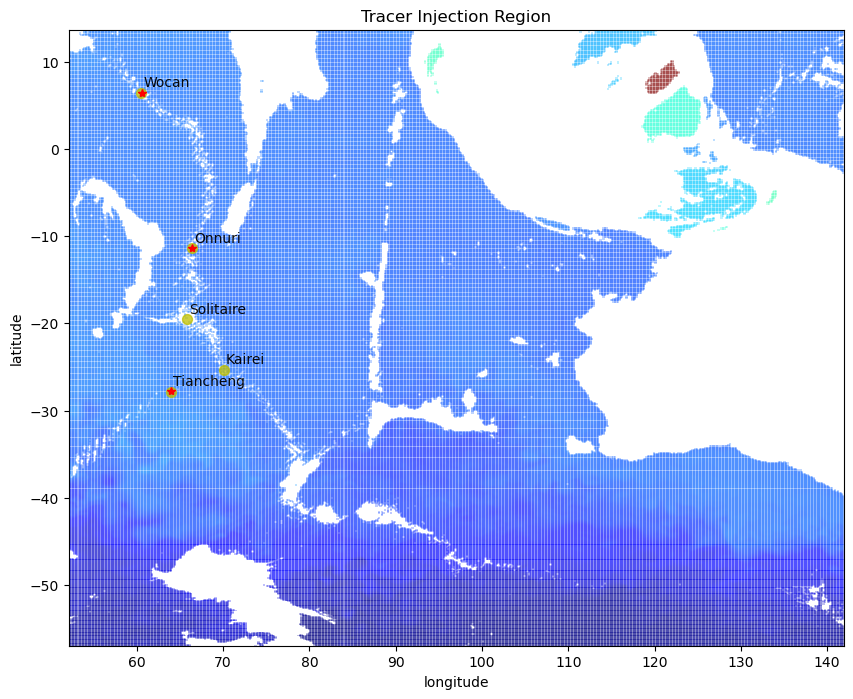

In [261]:
lons = ds.XC.sel(face=4).values
lats = ds.YC.sel(face=4).values
it00 = np.where((lons==0)&(lats==0))
lons[it00] = np.nan
lats[it00] = np.nan

fig=plt.figure(figsize=(10, 8))
# use contourf with 'lons' and 'lats' for the plot x and y axes
plt.pcolor(lons, lats, ds.T[-1].where(ds.maskC)[it1_wocan,4].values, cmap='jet',alpha=0.25)
plt.title('Tracer Injection Region')
plt.xlim(np.nanmin(lons),np.nanmax(lons))
plt.ylim(np.nanmin(lats),np.nanmax(lats))
plt.xlabel('longitude')
plt.ylabel('latitude')

it = np.where(relaxmask_ptracer[it1_wocan,4]>0.6)
plt.plot( lons[it], lats[it], 'r*' )
it = np.where(relaxmask_ptracer[it3_Onnuri,4]>0.6)
plt.plot( lons[it], lats[it], 'r*' )
it = np.where(relaxmask_ptracer[it4_Tiancheng,4]>0.6)
plt.plot( lons[it], lats[it], 'r*' )


plt.scatter(lonall, latall,s=50, c='y',marker='o',alpha=0.75)
for i in range(0,5):
    plt.text(lonall[i]+0.25,latall[i]+0.75,site[i], alpha=0.95 )



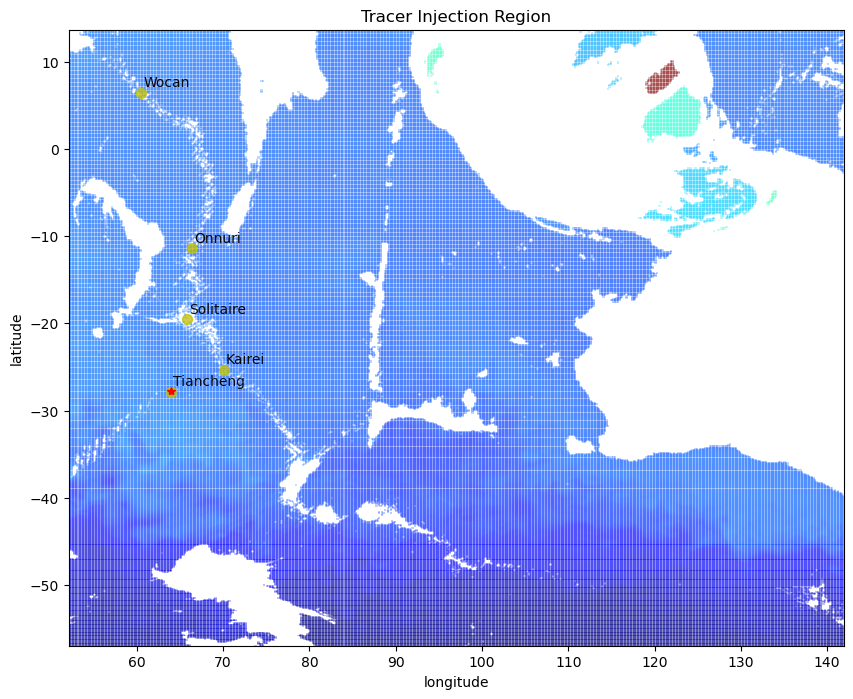

In [293]:

fig=plt.figure(figsize=(10, 8))
# use contourf with 'lons' and 'lats' for the plot x and y axes
plt.pcolor(lons, lats, ds.T[-1].where(ds.maskC)[it1_wocan,4].values, cmap='jet',alpha=0.25)
plt.title('Tracer Injection Region')
plt.xlim(np.nanmin(lons),np.nanmax(lons))
plt.ylim(np.nanmin(lats),np.nanmax(lats))
plt.xlabel('longitude')
plt.ylabel('latitude')

it = np.where(ptracer_onnuri[it1_wocan,4]>2e5)
plt.plot( lons[it], lats[it], 'r*' )
it = np.where(ptracer_onnuri[it3_Onnuri,4]>1e5)
plt.plot( lons[it], lats[it], 'r*' )
it = np.where(ptracer_onnuri[it4_Tiancheng,4]>1e5)
plt.plot( lons[it], lats[it], 'r*' )

plt.scatter(lonall, latall,s=50, c='y',marker='o',alpha=0.75)
for i in range(5):
    plt.text(lonall[i]+0.25,latall[i]+0.75,site[i], alpha=0.95 )



In [295]:
!ls ../input/*relaxmask*

../input/relaxmask_longqi.bin  ../input/relaxmask_tiancheng.bin
../input/relaxmask_onnuri.bin  ../input/relaxmask_wocan.bin


In [294]:
!ls ../input/*ptracer*

../input/ini_ptracer_longqi.bin  ../input/ini_ptracer_tiancheng.bin
../input/ini_ptracer_onnuri.bin  ../input/ini_ptracer_wocan.bin


In [307]:

testmask = xmitgcm.utils.read_raw_data('../input/ini_ptracer_tiancheng.bin', dtype=np.dtype('>f4'),
                                    shape=(63,7020,540) )

In [6]:
test = xmitgcm.utils.read_raw_data('../input/relaxmask_tiancheng.bin', dtype=np.dtype('>f4'),
                                    shape=(63,7020,540) )

In [ ]:
ds.hFacC[54,4,261,71].values

In [8]:
it = np.where(test>0.5)
it

(array([55]), array([2421]), array([71]))

In [308]:
it = np.where(testmask>2e5)

In [310]:
261+ 540*4

2421

In [309]:
it

(array([55]), array([2421]), array([71]))

In [91]:

xc540 = xmitgcm.utils.read_raw_data('../rundiurnal/XC.data', dtype=np.dtype('>f4'),
                                    shape=(7020,540) )


yc540 = xmitgcm.utils.read_raw_data('../rundiurnal/YC.data', dtype=np.dtype('>f4'),
                                    shape=(7020,540) )

hfackC = xmitgcm.utils.read_raw_data('../rundiurnal/hFacC.data', dtype=np.dtype('>f4'),  shape=(63,7020,540) )


In [105]:
xx, yy = np.meshgrid(np.arange(0,540,1),np.arange(0,7020,1))
xx[]

array([[  0,   1,   2, ..., 537, 538, 539],
       [  0,   1,   2, ..., 537, 538, 539],
       [  0,   1,   2, ..., 537, 538, 539],
       ...,
       [  0,   1,   2, ..., 537, 538, 539],
       [  0,   1,   2, ..., 537, 538, 539],
       [  0,   1,   2, ..., 537, 538, 539]])

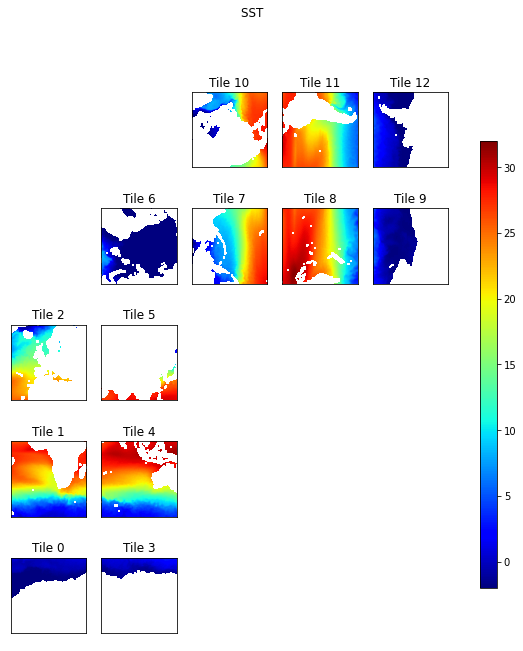

In [3]:

ecco.plot_tiles(ds_llc.THETA.where(ds_llc.maskC)[-1,0], \
                cmin=-2, \
                cmax=32, \
                show_colorbar=True);

# use `suptitle` (super title) to make a title over subplots.
plt.suptitle('SST ' );

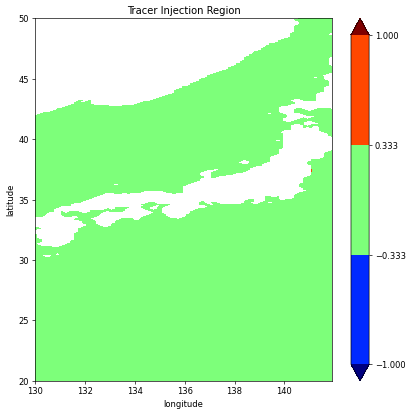

In [4]:
# pull out lats and lons
tile_num = 5
lons = eta.XC.sel(tile=tile_num)
lats = eta.YC.sel(tile=tile_num)
tile_to_plot = eta.isel(tile=tile_num, time=0)
tile_to_plot= tile_to_plot.where(ds_llc.hFacC.isel(tile=tile_num,k=0 ) !=0, np.nan)

tile_to_plot_tracer = eta.isel(tile=tile_num, time=0)
tile_to_plot_tracer = tile_to_plot_tracer.where( (lons>=141) & (lons<=141.2) & (lats>=37.3) & (lats<=37.6),0 )
tile_to_plot_tracer= tile_to_plot_tracer.where(ds_llc.hFacC.isel(tile=tile_num,k=0 ) !=0, np.nan)

fig=plt.figure(figsize=(8, 8),dpi=60)
# use contourf with 'lons' and 'lats' for the plot x and y axes
plt.contourf(lons, lats, tile_to_plot_tracer, np.linspace(-1,1, 4,endpoint=True), cmap='jet', vmin=-1, vmax=1,extend='both')
plt.title('Tracer Injection Region')
plt.xlim(130,np.max(lons))
plt.ylim(20,50)
plt.xlabel('longitude')
plt.ylabel('latitude')

plt.colorbar()


In [80]:
it = np.where((lons>=141) & (lons<=141.3) & (lats>=37.3) & (lats<=37.4))

In [81]:
it

(array([172, 172]), array([534, 535]))

In [54]:
ds_llc.Depth.sel(tile=tile_num)[172,534].values

array(30., dtype=float32)

In [57]:
ds_llc.Depth.sel(tile=tile_num)[172,535].values

array(110.47, dtype=float32)

In [65]:
itz = np.where(ds_llc.THETA[-1,:,tile_num,172,534]!=0)

In [67]:
ds_llc.THETA[-1,:,tile_num,172,534].values

array([20.66352 , 19.72108 , 19.028748,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ], dtype=float32)

In [69]:
ds_llc.Z.values

array([-5.000000e+00, -1.500000e+01, -2.500000e+01, -3.500000e+01,
       -4.500000e+01, -5.500000e+01, -6.500000e+01, -7.500500e+01,
       -8.502500e+01, -9.509500e+01, -1.053100e+02, -1.158700e+02,
       -1.271500e+02, -1.397400e+02, -1.544700e+02, -1.724000e+02,
       -1.947350e+02, -2.227100e+02, -2.574700e+02, -2.999300e+02,
       -3.506800e+02, -4.099300e+02, -4.774700e+02, -5.527100e+02,
       -6.347350e+02, -7.224000e+02, -8.144700e+02, -9.097400e+02,
       -1.007155e+03, -1.105905e+03, -1.205535e+03, -1.306205e+03,
       -1.409150e+03, -1.517095e+03, -1.634175e+03, -1.765135e+03,
       -1.914150e+03, -2.084035e+03, -2.276225e+03, -2.491250e+03,
       -2.729250e+03, -2.990250e+03, -3.274250e+03, -3.581250e+03,
       -3.911250e+03, -4.264250e+03, -4.640250e+03, -5.039250e+03,
       -5.461250e+03, -5.906250e+03], dtype=float32)

In [5]:
1/(30.172*365*86400)

1.0509675190164585e-09

In [86]:
1/86400

1.1574074074074073e-05

In [21]:

#ptracer=np.zeros([50,13,270,270],dtype='>f4')

lons = ds_llc.XC 
lats = ds_llc.YC 
Zs   = ds_llc.Z

ptracer = ds_llc.THETA.isel( time=0 )

ptracer = ptracer.where( (lons>=141) & (lons<=141.3) & (lats>=37.3) & (lats<=37.4) & (Zs<=-25.) & (Zs>=-30.),0 )

ptracer = ptracer.where( ptracer==0, 1e6 )

ptr_rbcmsk = ds_llc.THETA.isel( time=-1 )

ptr_rbcmsk = ptr_rbcmsk.where( (lons>=141) & (lons<=141.3) & (lats>=37.3) & (lats<=37.4) & (Zs<=-25.) & (Zs>=-30.), 1.050967519e-9 )

ptr_rbcmsk = ptr_rbcmsk.where( ptracer<2e-09, 1.157407407e-05 )



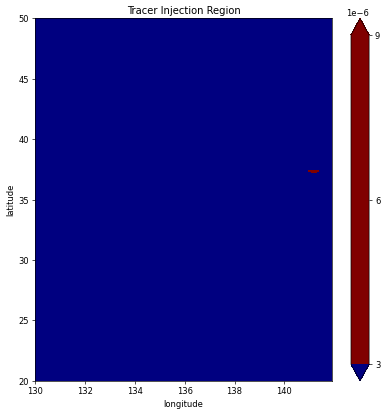

In [22]:
#### check initial ptracer
fig=plt.figure(figsize=(8, 8),dpi=60)
lons = ptracer.XC.sel(tile=tile_num)
lats = ptracer.YC.sel(tile=tile_num)
# use contourf with 'lons' and 'lats' for the plot x and y axes
#plt.contourf(lons, lats, ptracer[2].isel(tile=tile_num), np.linspace(-1,1, 4,endpoint=True), cmap='jet', vmin=-1, vmax=1,extend='both')
plt.contourf(lons, lats, ptr_rbcmsk[2].isel(tile=tile_num), levels=3, cmap='jet', vmin=-2e-9, vmax=2e-9,extend='both')

plt.title('Tracer Injection Region')
plt.xlim(130,np.max(lons))
plt.ylim(20,50)
plt.xlabel('longitude')
plt.ylabel('latitude')

plt.colorbar()

In [24]:
ptr_rbcmsk[2].isel(tile=tile_num).values[0,0]

1.0509675e-09

In [25]:
outputdir = '/data/home/liuran/MITgcm_works/llc540/input/'


ptracer = ptracer.rename({'tile':'face'})
ptr_rbcmsk = ptr_rbcmsk.rename({'tile':'face'})

facets = xmitgcm.utils.rebuild_llc_facets( ptracer,llc540_extra_metadata )
compact = xmitgcm.utils.llc_facets_3d_spatial_to_compact(facets, 'Z',llc540_extra_metadata )
xmitgcm.utils.write_to_binary(compact, outputdir+'Ini_137Cs_llc540.bin')


facets = xmitgcm.utils.rebuild_llc_facets( ptr_rbcmsk,llc540_extra_metadata )
compact = xmitgcm.utils.llc_facets_3d_spatial_to_compact(facets, 'Z',llc540_extra_metadata )
xmitgcm.utils.write_to_binary(compact, outputdir+'Ini_137Cs_rbcmsk_llc540.bin')


In [321]:
5.9728941962803E-06 + 5.4499021563540E-06 + 2.5584882356535E-06 + 9.2842671593016E-07 -1.2370425200654E-06 
-4.0661145856384E-06 + -2.3330482543066E-06 + -3.2455018703583E-06 + 1.0373180246024E-06 + 3.0004573657818E-06 
+5.3064971143780E-06 + 6.2371204410157E-06

1.1543617555393699e-05

In [ ]:
1.1543617555393699e-05


In [327]:
5.9728941962803E-06 + 5.4499021563540E-06 + 2.5584882356535E-06 + 9.2842671593016E-07 -1.2370425200654E-06 
-4.0661145856384E-06 + -2.3330482543066E-06 + -3.2455018703583E-06 + 1.0373180246024E-06 + 3.0004573657818E-06 
+5.3064971143780E-06 + 6.2371204410157E-06 + 4.9208491866791E-06 + 5.6192379711138E-06

2.2083704713186598e-05

In [ ]:
#eta


In [ ]:
-9.0139675491897E-01 -9.1372394114050E-01  -9.2331031757166E-01 -9.2601974931733E-01 -9.2700625966810E-01 -9.1670700630164E-01
-9.0471727499872E-01 -8.9974518216150E-01 -9.0076622348827E-01 -9.0572041859716E-01  -9.1315223504912E-01 -9.2578513007373E-01

/tmp/ipykernel_399090/18992927.py:24: RuntimeWarning: overflow encountered in exp
  z_scarp = z1 / (1 + np.exp(-k * (x - scarp_location)))


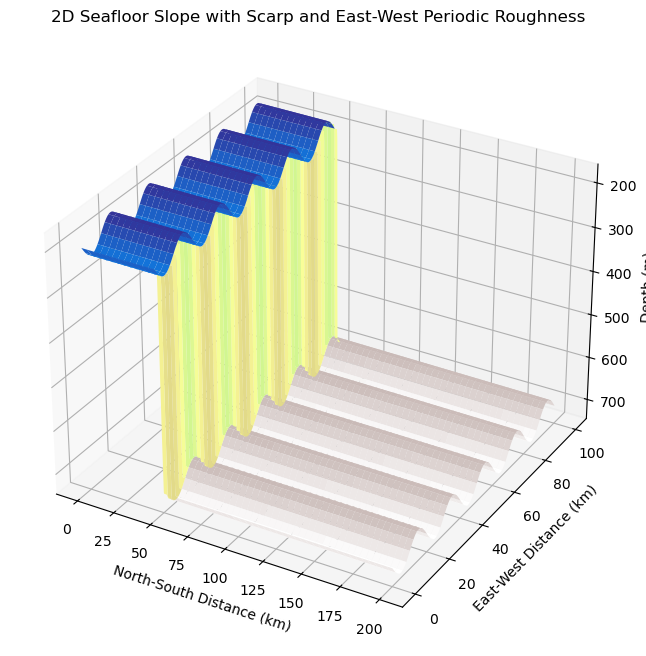

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parameters
x = np.linspace(0, 200, 1000)  # North-south direction (distance in km)
y = np.linspace(0, 100, 500)   # East-west direction (distance in km, periodic)
x, y = np.meshgrid(x, y)  # Create a 2D grid for the x and y directions

# Depth parameters
z0 = 200  # Reference depth (meters)
slope = 0.02  # Slope in the north-south direction
scarp_location = 50  # Location of the scarp (in km)
z1 = 500  # Depth change across the scarp (in meters)
k = 20  # Steepness of the scarp
A = 30  # Amplitude of the roughness (in meters)
L_y = 20  # Wavelength of the roughness in the east-west direction (in km)
phi = 0  # Phase shift of the sinusoidal roughness

# Construct the slope in the north-south direction
z_slope = z0 + slope * x

# Add the scarp using a sigmoidal function
z_scarp = z1 / (1 + np.exp(-k * (x - scarp_location)))

# Add periodic roughness in the east-west direction
z_roughness = A * np.sin(2 * np.pi * y / L_y + phi)

# Combine all components to get the final seafloor depth
z = z_slope + z_scarp + z_roughness

# Plot the seafloor topography using a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='terrain', edgecolor='none')
ax.set_xlabel('North-South Distance (km)')
ax.set_ylabel('East-West Distance (km)')
ax.set_zlabel('Depth (m)')
ax.set_title('2D Seafloor Slope with Scarp and East-West Periodic Roughness')
ax.invert_zaxis()  # Depth increases downward
plt.show()

/tmp/ipykernel_399090/4158980143.py:50: RuntimeWarning: overflow encountered in exp
  z += z1 / (1 + np.exp(-k * (y - scarp_location)))


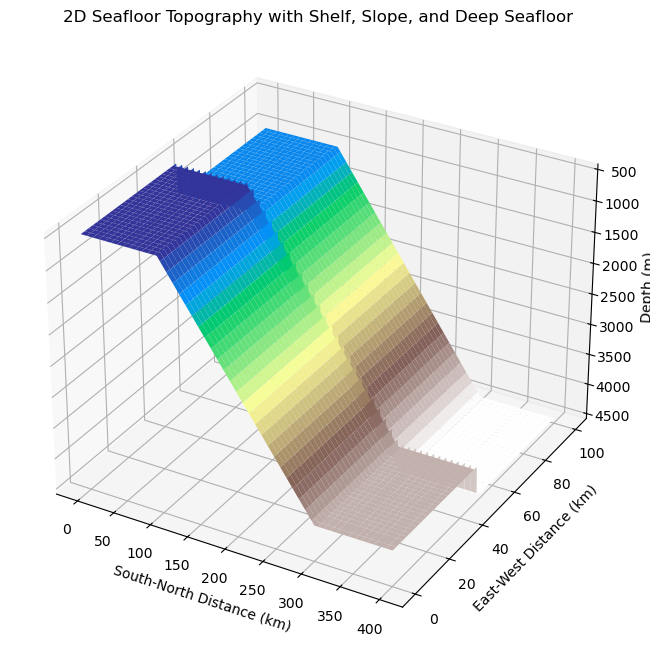

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parameters
x = np.linspace(0, 400, 1000)  # South-north direction (0 to 400 km)
y = np.linspace(0, 100, 500)   # East-west direction (0 to 100 km, periodic)
x, y = np.meshgrid(x, y)  # Create a 2D grid for the x and y directions

# Depth parameters
z_max = 4000  # Maximum depth (4000 meters)
shelf_depth = 500  # Depth of the shelf (200 meters)
slope_length = 200  # Length of the slope (200 km)
shelf_length = 100  # Length of the shelf (100 km)
deep_length = 100  # Length of the deep seafloor (100 km)
slope_steepness = (z_max - shelf_depth) / slope_length  # Slope steepness

# Roughness parameters
A = 100  # Amplitude of the roughness (in meters)
L_y = 7  # Wavelength of the roughness in the east-west direction (in km)
phi = 0  # Phase shift of the sinusoidal roughness

z1 = 500  # Depth change across the scarp (in meters)
k = 20  # Steepness of the scarp


# Define the bathymetry model
def seafloor_bathymetry(x, y):
    # Initialize depth
    z = np.zeros_like(x)
    
    # Shelf region: x in [0, 100]
    shelf_mask = (x <= shelf_length)
    z[shelf_mask] = shelf_depth
    
    # Slope region: x in [100, 300]
    slope_mask = (x > shelf_length) & (x <= shelf_length + slope_length)
    z[slope_mask] = shelf_depth + slope_steepness * (x[slope_mask] - shelf_length)
    
    # Deep seafloor region: x in [300, 400]
    deep_mask = (x > shelf_length + slope_length)
    z[deep_mask] = z_max
    
    ## Add periodic roughness in the east-west direction
    #z += A * np.sin(2 * np.pi * y / L_y + phi)
    
    # Add the scarp using a sigmoidal function
    #z_scarp = z1 / (1 + np.exp(-k * (x - scarp_location)))
    
    z += z1 / (1 + np.exp(-k * (y - scarp_location)))
    #scarps_depths[i] / (1 + np.exp(-scarps_steepness[i] * (y - scarps_locations[i])))
    return z

# Compute the seafloor topography
z = seafloor_bathymetry(x, y)

# Plot the seafloor topography using a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='terrain', edgecolor='none')
ax.set_xlabel('South-North Distance (km)')
ax.set_ylabel('East-West Distance (km)')
ax.set_zlabel('Depth (m)')
ax.set_title('2D Seafloor Topography with Shelf, Slope, and Deep Seafloor')
ax.invert_zaxis()  # Depth increases downward
plt.show()

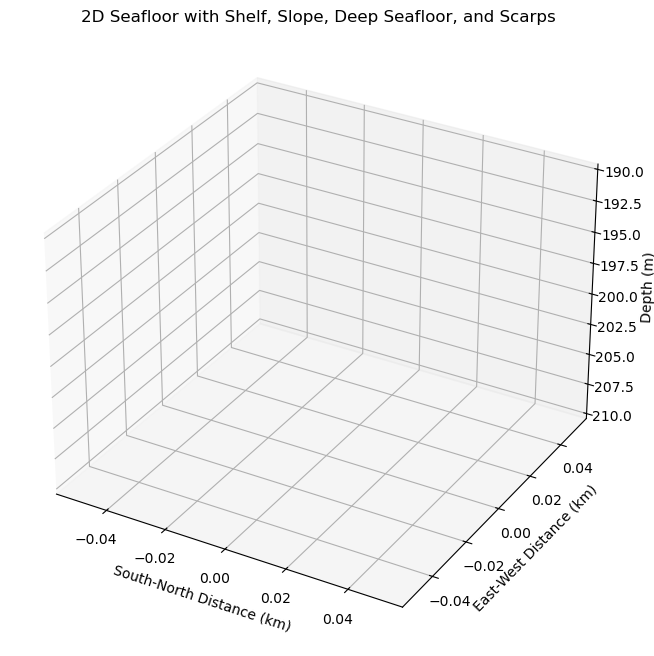

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parameters for grid
x = np.linspace(0, 400, 1)  # South-north direction (0 to 400 km)
y = np.linspace(0, 400, 1)   # East-west direction (0 to 400 km)
x, y = np.meshgrid(x, y)  # Create a 2D grid for the x and y directions

# Depth parameters
z_max = 4000  # Maximum depth (4000 meters)
shelf_depth = 200  # Depth of the shelf (200 meters)
slope_length = 200  # Length of the slope (200 km)
shelf_length = 100  # Length of the shelf (100 km)
deep_length = 100  # Length of the deep seafloor (100 km)
slope_steepness = (z_max - shelf_depth) / slope_length  # Slope steepness

# Scarps parameters
scarps_depths = [200, 300, 250, 400, 350, 150, 500]  # Depth change for each scarp
scarps_locations = np.linspace(0, 400, 8)[1:-1]  # Scarp centers along the east-west direction
scarps_widths = np.random.uniform(7, 10, size=7)  # Random widths between 7 and 10 km
scarps_steepness = 10 / scarps_widths  # Steepness is inversely related to width

# Roughness parameters
A = 100  # Amplitude of the roughness (in meters)
L_y = 20  # Wavelength of the roughness in the east-west direction (in km)
phi = 0  # Phase shift of the sinusoidal roughness

# Define the bathymetry model
def seafloor_bathymetry(x, y):
    # Initialize depth
    z = np.zeros_like(x)
    
    # Shelf region: x in [0, 100]
    shelf_mask = (x <= shelf_length)
    z[shelf_mask] = shelf_depth
    
    # Slope region: x in [100, 300]
    slope_mask = (x > shelf_length) & (x <= shelf_length + slope_length)
    z[slope_mask] = shelf_depth + slope_steepness * (x[slope_mask] - shelf_length)
    
    # Deep seafloor region: x in [300, 400]
    deep_mask = (x > shelf_length + slope_length)
    z[deep_mask] = z_max
    
    # Add periodic roughness in the east-west direction
    z += A * np.sin(2 * np.pi * y / L_y + phi)
    
    ## Add scarps in the east-west direction
    #for i in range(len(scarps_locations)):
    #    z += scarps_depths[i] / (1 + np.exp(-scarps_steepness[i] * (y - scarps_locations[i])))
    
    return z

# Compute the seafloor topography
z = seafloor_bathymetry(x, y)

# Plot the seafloor topography using a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='terrain', edgecolor='none')
ax.set_xlabel('South-North Distance (km)')
ax.set_ylabel('East-West Distance (km)')
ax.set_zlabel('Depth (m)')
ax.set_title('2D Seafloor with Shelf, Slope, Deep Seafloor, and Scarps')
ax.invert_zaxis()  # Depth increases downward
plt.show()

In [74]:
test = 1 / (1 + np.exp(-k * (y - scarp_location)))

/tmp/ipykernel_399090/4181222855.py:1: RuntimeWarning: overflow encountered in exp
  test = 1 / (1 + np.exp(-k * (y - scarp_location)))


In [101]:
import numpy as np
import matplotlib.pyplot as plt

# Define constants
Nx = 400
Ny = 448
m1km = 1000
Ws = 25 * m1km
Lx = 400 * m1km
Ly = 450 * m1km
H = 4000


use_trough = False

# Topographic parameters
Hshelf = 500
Hs = H - Hshelf
Ys = 150 * m1km

# Trough parameters
N_trough = 4
H_trough = 300
H_bump = -H_trough
W_trough = Lx / N_trough / 4

X_trough = np.zeros(N_trough)
X_bump = np.zeros(N_trough)
for nrt in range(N_trough):
    X_trough[nrt] = (2 * nrt + 1 - N_trough) / 2 * Lx / N_trough
    X_bump[nrt] = (2 * nrt - N_trough) / 2 * Lx / N_trough

Y_trough = 0 * m1km

if use_trough:
    Zs = 2250 + H_trough / 2 * N_trough
else:
    Zs = 2250

# Zonal grid
dx = Lx / Nx
xx = np.arange(1, Nx + 1) * dx
xx = xx - np.mean(xx)

# Uniform meridional grid
dy = (Ly / Ny) * np.ones(Ny)
yy = np.cumsum((dy + np.concatenate(([0], dy[:-1]))) / 2)

# Plotting mesh
Y, X = np.meshgrid(yy, xx)

z_topog = Zs * np.ones_like(X)
h_topog = Hs * np.ones_like(X)

if use_trough:
    for ntr in range(N_trough):
        h_trough = H_trough * np.exp(-((X - X_trough[ntr]) / W_trough) ** 4)
        h_trough[Y < Y_trough] = 0
        yidx = (yy > Y_trough) & (yy < Ys - Ws)
        h_trough[:, yidx] *= 0.5 * (1 - np.cos(np.pi * (Y[:, yidx] - Y_trough) / (Ys - Ws - Y_trough)))
        z_topog = (z_topog - 0.5 * H_trough) + h_trough
        h_topog -= 2 * h_trough

# Define parameters for additional structures
structure_width = 6 * m1km
structure_length = 75 * m1km
structure_height = 200

# Random X positions for structures
num_structures = 20
random_x_positions = np.random.uniform(-Lx/2, Lx/2, num_structures)

# Determine the range for structures along the y-axis (shelf edge)
y_structure_start = Ys - structure_length / 2 -50
y_structure_end = Ys + structure_length / 2 -50

# Add structures
for x_pos in random_x_positions:
    for i in range(Nx):
        for j in range(Ny):
            if y_structure_start <= yy[j] <= y_structure_end:
                distance = abs(xx[i] - x_pos)
                if distance <= structure_width / 2:
                    h_topog[i, j] -= structure_height * np.exp(-(distance / (structure_width / 2)) ** 2)

# Recalculate the final topography
h = -z_topog - (h_topog / 2) * np.tanh((Y - Ys) / Ws)


In [140]:
import numpy as np
import matplotlib.pyplot as plt

# Define constants
Nx = 400
Ny = 448
m1km = 1000
Ws = 25 * m1km
Lx = 400 * m1km
Ly = 450 * m1km
H = 4000

use_trough = False

# Topographic parameters
Hshelf = 500
Hs = H - Hshelf
Ys = 150 * m1km

# Trough parameters
N_trough = 4
H_trough = 300
H_bump = -H_trough
W_trough = Lx / N_trough / 4

X_trough = np.zeros(N_trough)
X_bump = np.zeros(N_trough)
for nrt in range(N_trough):
    X_trough[nrt] = (2 * nrt + 1 - N_trough) / 2 * Lx / N_trough
    X_bump[nrt] = (2 * nrt - N_trough) / 2 * Lx / N_trough

Y_trough = 0 * m1km

if use_trough:
    Zs = 2250 + H_trough / 2 * N_trough
else:
    Zs = 2250

# Zonal grid
dx = Lx / Nx
xx = np.arange(1, Nx + 1) * dx
xx = xx - np.mean(xx)

# Uniform meridional grid
dy = (Ly / Ny) * np.ones(Ny)
yy = np.cumsum((dy + np.concatenate(([0], dy[:-1]))) / 2)

# Plotting mesh
Y, X = np.meshgrid(yy, xx)

z_topog = Zs * np.ones_like(X)
h_topog = Hs * np.ones_like(X)

if use_trough:
    for ntr in range(N_trough):
        h_trough = H_trough * np.exp(-((X - X_trough[ntr]) / W_trough) ** 4)
        h_trough[Y < Y_trough] = 0
        yidx = (yy > Y_trough) & (yy < Ys - Ws)
        h_trough[:, yidx] *= 0.5 * (1 - np.cos(np.pi * (Y[:, yidx] - Y_trough) / (Ys - Ws - Y_trough)))
        z_topog = (z_topog - 0.5 * H_trough) + h_trough
        h_topog -= 2 * h_trough

# Define parameters for additional structures
structure_width = 6 * m1km
structure_length = 150 * m1km

# Random X positions for structures
num_structures = 30
random_x_positions = np.random.uniform(-Lx/2, Lx/2, num_structures)

# Random heights for scarps and ridges
random_heights = np.random.choice([-200, 200], num_structures)

# Determine the range for structures along the y-axis (shelf edge)
y_structure_start = Ys - structure_length / 2 -100
y_structure_end = Ys + structure_length / 2 -100

# Add structures
for x_pos, height in zip(random_x_positions, random_heights):
    for i in range(Nx):
        for j in range(Ny):
            if y_structure_start <= yy[j] <= y_structure_end:
                distance = abs(xx[i] - x_pos)
                if distance <= structure_width / 2:
                    h_topog[i, j] += height * np.exp(-(distance / (structure_width / 2)) ** 2)

# Recalculate the final topography
h = -z_topog - (h_topog / 2) * np.tanh((Y - Ys) / Ws)


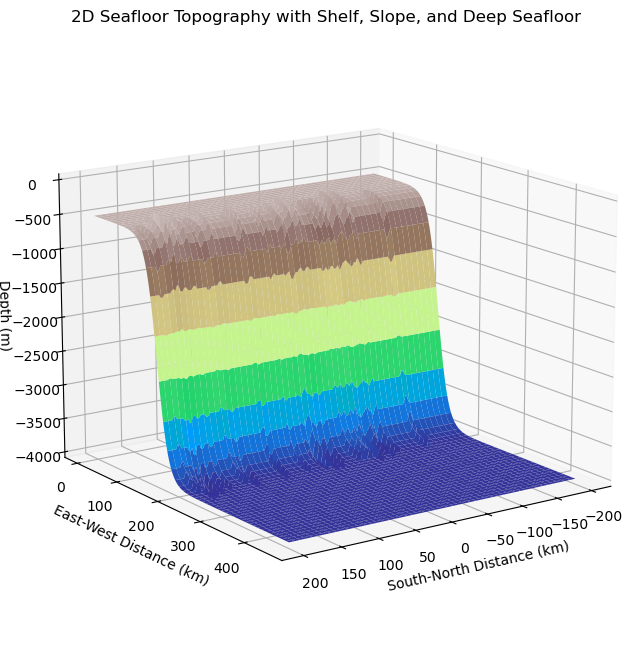

In [141]:
# Plot the seafloor topography using a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X/1e3,Y/1e3, h, cmap='terrain', edgecolor='none',vmin=-4000,vmax=0)
ax.set_xlabel('South-North Distance (km)')
ax.set_ylabel('East-West Distance (km)')
ax.set_zlabel('Depth (m)')
ax.set_title('2D Seafloor Topography with Shelf, Slope, and Deep Seafloor')
ax.view_init(elev=15, azim=55, roll=0)
ax.set_zlim(-4000,0)
#ax.invert_zaxis()  # Depth increases downward
plt.show()


In [145]:
h_topog.shape

(400, 448)

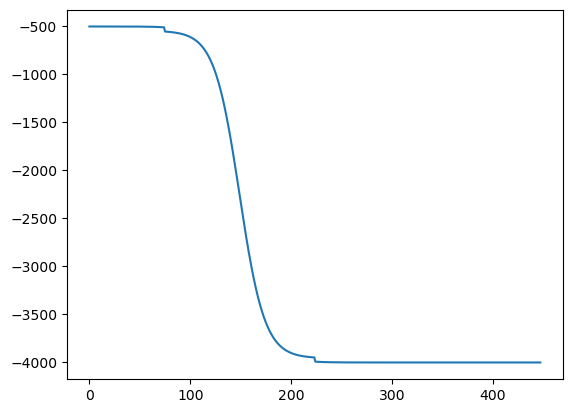

In [154]:
plt.plot(h[200,:])


In [159]:
import numpy as np
import matplotlib.pyplot as plt

# Define constants
Nx = 400
Ny = 448
m1km = 1000
Ws = 25 * m1km
Lx = 400 * m1km
Ly = 450 * m1km
H = 4000

use_trough = False

# Topographic parameters
Hshelf = 500
Hs = H - Hshelf
Ys = 150 * m1km

# Trough parameters
N_trough = 4
H_trough = 300
H_bump = -H_trough
W_trough = Lx / N_trough / 4

X_trough = np.zeros(N_trough)
X_bump = np.zeros(N_trough)
for nrt in range(N_trough):
    X_trough[nrt] = (2 * nrt + 1 - N_trough) / 2 * Lx / N_trough
    X_bump[nrt] = (2 * nrt - N_trough) / 2 * Lx / N_trough

Y_trough = 0 * m1km

if use_trough:
    Zs = 2250 + H_trough / 2 * N_trough
else:
    Zs = 2250

# Zonal grid
dx = Lx / Nx
xx = np.arange(1, Nx + 1) * dx
xx = xx - np.mean(xx)

# Uniform meridional grid
dy = (Ly / Ny) * np.ones(Ny)
yy = np.cumsum((dy + np.concatenate(([0], dy[:-1]))) / 2)

# Plotting mesh
Y, X = np.meshgrid(yy, xx)

z_topog = Zs * np.ones_like(X)
h_topog = Hs * np.ones_like(X)

if use_trough:
    for ntr in range(N_trough):
        h_trough = H_trough * np.exp(-((X - X_trough[ntr]) / W_trough) ** 4)
        h_trough[Y < Y_trough] = 0
        yidx = (yy > Y_trough) & (yy < Ys - Ws)
        h_trough[:, yidx] *= 0.5 * (1 - np.cos(np.pi * (Y[:, yidx] - Y_trough) / (Ys - Ws - Y_trough)))
        z_topog = (z_topog - 0.5 * H_trough) + h_trough
        h_topog -= 2 * h_trough

# Parameters for tree-like structures
structure_width = 6 * m1km
structure_height = 200

# Recursive function to create tree-like structures
def add_branch(x, y, width, height, depth):
    if depth == 0:
        return
    # Calculate the influence of the current branch
    for i in range(Nx):
        for j in range(Ny):
            distance = np.sqrt((xx[i] - x) ** 2 + (yy[j] - y) ** 2)
            if distance <= width:
                h_topog[i, j] += height * np.exp(-(distance / width) ** 2)
    # Recursive branching
    new_width = width / 2
    new_height = height / 2
    add_branch(x + new_width, y + new_width, new_width, new_height, depth - 1)
    add_branch(x - new_width, y + new_width, new_width, new_height, depth - 1)

# Random starting positions for tree-like structures
num_structures = 30
random_positions = np.random.uniform(-Lx/2, Lx/2, (num_structures, 2))

# Add tree-like structures
for x_pos, y_pos in random_positions:
    add_branch(x_pos, y_pos, structure_width, structure_height, 3)

# Recalculate the final topography
h = -z_topog - (h_topog / 2) * np.tanh((Y - Ys) / Ws)


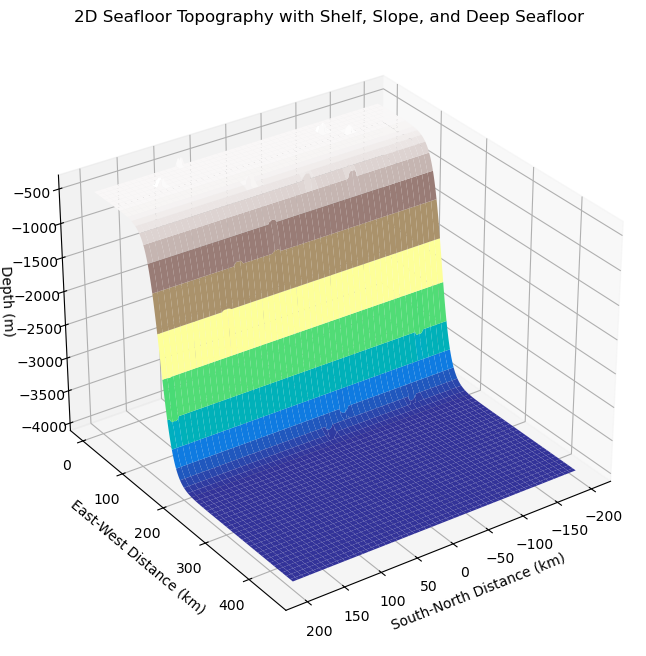

In [160]:
# Plot the seafloor topography using a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X/1e3,Y/1e3, h, cmap='terrain', edgecolor='none')
ax.set_xlabel('South-North Distance (km)')
ax.set_ylabel('East-West Distance (km)')
ax.set_zlabel('Depth (m)')
ax.set_title('2D Seafloor Topography with Shelf, Slope, and Deep Seafloor')
ax.view_init(elev=30, azim=55, roll=0)

#ax.invert_zaxis()  # Depth increases downward
plt.show()


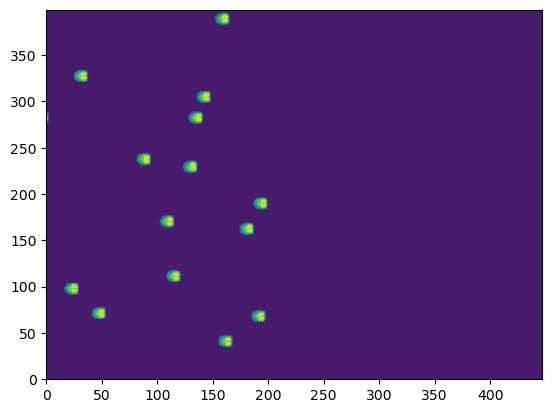

In [161]:
plt.contourf(h_topog)

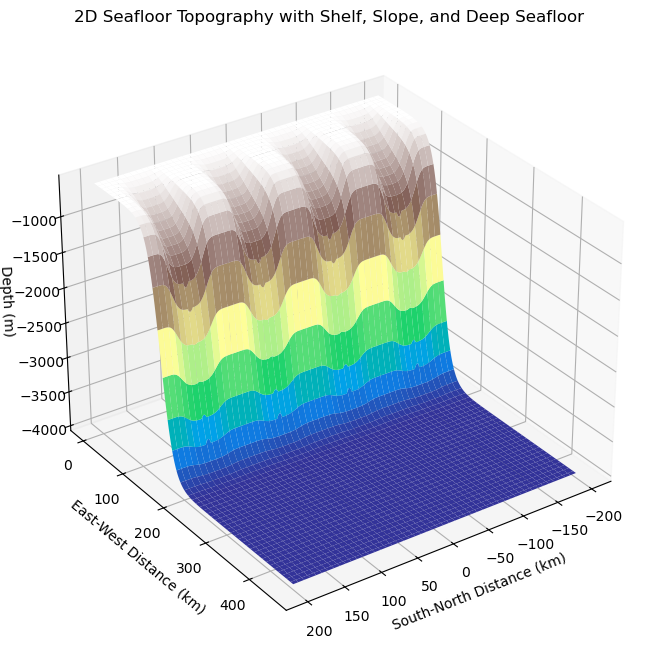

In [90]:
# Plot the seafloor topography using a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X/1e3,Y/1e3, h, cmap='terrain', edgecolor='none')
ax.set_xlabel('South-North Distance (km)')
ax.set_ylabel('East-West Distance (km)')
ax.set_zlabel('Depth (m)')
ax.set_title('2D Seafloor Topography with Shelf, Slope, and Deep Seafloor')
ax.view_init(elev=30, azim=55, roll=0)

#ax.invert_zaxis()  # Depth increases downward
plt.show()
